<a href="https://colab.research.google.com/github/gmauricio-toledo/NLP-MCD/blob/main/13-BERT-SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>BERT</h1>

En esta notebook exploraremos el uso de modelos tipo BERT para resolver la tarea de *Análisis de Sentimientos*. Esto lo haremos de dos formas:

1. Haciendo fine-tuning a un modelo BERT.
2. Usando los embeddings generados por BERT como features para un algoritmo de ML.

Usaremos modelos pre-entrenados almacenados en [HuggingFace](https://huggingface.co/).

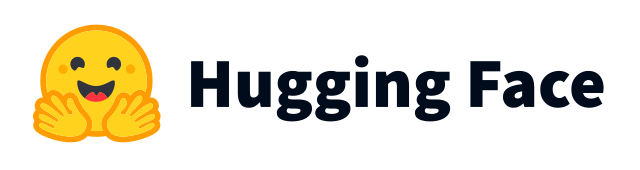

---

*Hugging Face, Inc. es una empresa estadounidense conocida por su biblioteca de transformadores creada para aplicaciones de procesamiento de lenguaje natural y su plataforma que permite a los usuarios compartir [datasets](https://huggingface.co/datasets) y [modelos](https://huggingface.co/models) de aprendizaje automático.  Su campo de acción principal es el NLP, pero también se centra en otras áreas del ML, como la visión de máquina, el aprendizaje por refuerzo y el aprendizaje supervisado.*

---

# 🔴 Tarea:

Usando otro modelo tipo BERT (DeBERTa, ALBERT, ELECTRA, etc), realiza la tarea de clasificación en el dataset de reviews de turismo en español.

Aquí hay dos desafios que explorar:

1. ¿Los modelos anteriores se pueden usar en español?
2. Buscar un modelo específico en español.

Para esta tarea, realiza una división *train/test* similar a la hecha en la práctica anterior con este dataset.

Para realizar el entrenamiento puedes usar la estrategia (1.A) o la clase `Trainer`.

## Utilizando un modelo de tipo BERT "normal"

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import nltk
from nltk import word_tokenize
import re
from string import punctuation

nltk.download('punkt') # este ya va de salida
nltk.download('punkt_tab')
nltk.download('stopwords')

stopwords = nltk.corpus.stopwords.words('spanish')

[nltk_data] Downloading package punkt to /home/jesusg/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/jesusg/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jesusg/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
train_df = pd.read_csv('../../datasets/pln/resenas/train.csv', index_col=0)
train_df.head()

,Title,Opinion,Place,Gender,Age,Country,Date,Label
0,"""No es para recomendarse""","""Las famosas momias de Guanajuato. El museo en...",Museo de las Momias,Male,48,México,02/07/2013,0
1,"""Es un mercado tradicional, no es nada del otr...","""Allí puedes encontrar comida o souvenirs. Es ...",Mercado Hidalgo,Male,52,México,06/09/2016,0
2,"""No visitar""","""Es tardado entrar al museo, una vez dentro no...",Museo de las Momias,Male,42,México,25/12/2017,0
3,"""No le veo atractivo. A ver semejantes cacharros""","""Entiendo que a muchos les cautive o llamé la ...",Museo de las Momias,Female,24,México,14/08/2013,0
4,"""Nada fuera de lo común""","""La fruta y verdura son poco frescos, al igual...",Mercado Hidalgo,Female,19,México,01/08/2017,0


In [3]:
test_df = pd.read_csv('../../datasets/pln/resenas/test_features.csv',index_col=0)
test_df.head()

,Title,Opinion,Place,Gender,Age,Country,Date
0,"""No coman ahí""","""Creo que es muy insalubre, hay basura por tod...",Mercado Hidalgo,Female,61,México,15/01/2013
1,"""Romántico""","""Es un callejón común donde todos toman fotos ...",Callejón del Beso,Female,42,Uruguay,22/06/2015
2,Muy descuidado,"Cierto, es un mercado, pero no por eso hay que...",Mercado Hidalgo,Male,-1,México,2019
3,"""Impresionante""","""El acabado del altar es sumamente bonito, aun...",Basilica Colegiata,Male,26,México,08/10/2013
4,"""No es lo máximo""","""De todo lo hermoso que tiene Guanajuato esto ...",Basilica Colegiata,Female,54,México,10/01/2012


In [4]:
def process_training_df(df):
    df.drop(columns=['Place','Gender','Age','Country','Date'])
    df['text'] = df['Title'].str.replace(r'"', ' ', regex=True) + ' ' + df['Opinion'].str.replace(r'"', ' ', regex=True)
    df['text'] = df['text'].str.replace(r'\d+',' ', regex=True)
    df['text'] = df['text'].str.replace(r'[¿¡]',' ', regex=True)
    df
    if 'Label' in df.columns:
        df = df[['text','Label']]
        return df
    else:
        df = df[['text']]
        return df

In [5]:
train_df_processed = process_training_df(train_df)
train_df_processed.head()

,text,Label
0,No es para recomendarse Las famosas momias ...,0
1,"Es un mercado tradicional, no es nada del otr...",0
2,"No visitar Es tardado entrar al museo, una ...",0
3,No le veo atractivo. A ver semejantes cacharr...,0
4,Nada fuera de lo común La fruta y verdura s...,0


In [6]:
test_df_processed = process_training_df(test_df)
test_df_processed.head()

,text
0,"No coman ahí Creo que es muy insalubre, hay..."
1,Romántico Es un callejón común donde todos ...
2,"Muy descuidado Cierto, es un mercado, pero no ..."
3,Impresionante El acabado del altar es sumam...
4,No es lo máximo De todo lo hermoso que tien...


In [7]:
X_train, X_val, y_train, y_val = train_test_split(train_df_processed['text'], train_df_processed['Label'], test_size=0.25, random_state=42, stratify=train_df_processed['Label'])

In [8]:
y_test = np.load('../../datasets/pln/resenas/test_labels.npy')

In [9]:
def tokenize_text(text):
    tokens = word_tokenize(text)  # Tokenize the text
    filtered_tokens = [
        token.lower() for token in tokens 
        if token.lower() not in stopwords and token not in punctuation
    ]
    return filtered_tokens

In [10]:
X_train_tokenized = X_train.astype(str).apply(tokenize_text).apply(' '.join)
X_val_tokenized = X_val.apply(tokenize_text).apply(' '.join)
X_test_tokenized = test_df_processed['text'].astype(str).apply(tokenize_text).apply(' '.join)

In [11]:
X_train_tokenized

2892    tétrico divertido quién ocurre hacer museo lle...
3340    hermoso lugar historico hermoso lugar historic...
660     hermosa vista atractivo lugar hermosa vista pa...
3418    buena música centro vida nocturna alrededor va...
1889    impactante edificio halla zona sencilla ciudad...
                              ...                        
2607    recrear vista pípila personaje mítico zona ind...
1607    espectacular encantó contraten historiador tan...
3126    hermoso templo tocó conocerla noche celebrándo...
680     beso beso mal organizado acceso peligroso cant...
3917    emblema ciudad universidad mucha tradición ade...
Name: text, Length: 3312, dtype: object

Average training text length: 174.89341787439614
Average test text length: 178.5
Average validation text length: 174.4099547511312


/tmp/ipykernel_2563/2207889412.py:39: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


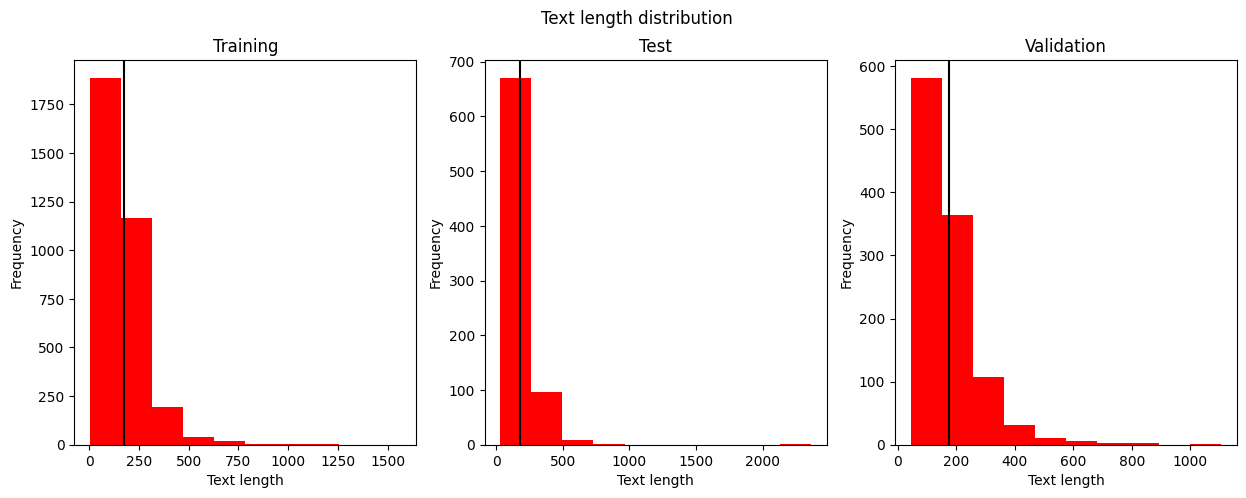

In [12]:
train_lengths = []
test_lengths = []
val_lengths = []

for doc in X_train_tokenized:
    train_lengths.append(len(doc))

for doc in X_test_tokenized:
    test_lengths.append(len(doc))

for doc in X_val_tokenized:
    val_lengths.append(len(doc))

avg_train_text_length = np.mean(train_lengths)
avg_test_text_length = np.mean(test_lengths)
avg_val_text_length = np.mean(val_lengths)

print(f"Average training text length: {avg_train_text_length}")
print(f"Average test text length: {avg_test_text_length}")
print(f"Average validation text length: {avg_val_text_length}")

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Text length distribution')
axs[0].hist(train_lengths, color='red')
axs[0].axvline(avg_train_text_length, color='black')
axs[0].set_xlabel('Text length')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Training')
axs[1].hist(test_lengths, color='red')
axs[1].axvline(avg_test_text_length, color='black')
axs[1].set_xlabel('Text length')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Test')
axs[2].hist(val_lengths, color='red')
axs[2].axvline(avg_val_text_length, color='black')
axs[2].set_xlabel('Text length')
axs[2].set_ylabel('Frequency')
axs[2].set_title('Validation')
fig.show()

#### Cargando el modelo `ALBERT` y su tokenizador

In [13]:
from transformers import AlbertTokenizerFast

tokenizer = AlbertTokenizerFast.from_pretrained('albert/albert-base-v2')

In [14]:
train_encodings = tokenizer(list(X_train_tokenized), truncation=True, padding=True)
val_encodings = tokenizer(list(X_val_tokenized), truncation=True, padding=True)
test_encodings = tokenizer(list(X_test_tokenized), truncation=True, padding=True)

In [15]:
print(X_train_tokenized[0])
for idx in train_encodings['input_ids'][0]:
    print(f"{idx}: {tokenizer.decode(idx)}")

recomendarse famosas momias guanajuato museo horrible exhiben sino exhiben abuelo contó hace años visitar momias entrar panteón pasear tumbas darle propina sepulturero levantaba pesada aldaba después bajar escalera caracol lúgubre cripta ahí cuerpos alineados tras ambos lados estrecho pasillo pasar cristales medio suena escalofriante auténtico ... debieron haber dejado así limitar número personas pudieran visitar diariamente quizás unas haber cobrado bueno ve museo buena fuente ingresos erario bella ciudad recomiendo visitarlo sólo si visitaron todas demás atracciones bellezas ofrece guanajuato si queda tiempo pues bien


2024-11-21 13:15:08.586965: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-21 13:15:08.930153: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732220109.016819    2563 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732220109.056830    2563 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-21 13:15:09.383721: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

2: [CLS]
2392: te
38: t
21663: rico
19610: divert
6470: ido
9153: qui
219: en
635: o
4734: cur
99: re
1458: ha
5482: cer
22557: museo
13: 
6696: lle
251: no
8762: cad
11937: aver
160: es
1641: mom
24831: ifica
8609: dos
1612: lu
2063: gar
926: di
2407: fer
7989: ente
10457: pes
512: ar
4245: ser
1612: lu
2063: gar
652: ten
62: e
5069: bro
656: so
5750: pas
58: a
3183: bu
219: en
4595: rat
111: o
1790: vi
219: en
537: do
20: to
8016: das
1641: mom
9814: ias
1641: mom
9814: ias
29545: conserva
537: do
28: as
49: i
5120: gra
4321: cia
18: s
272: c
22861: lima
1396: ex
20626: cep
10934: cion
192: al
18155: guan
58: a
2142: ju
6043: ato
21: a
546: de
5250: mas
13: 
20963: cada
1396: ex
8630: hib
3405: ida
18: s
10963: cue
10985: nta
12406: deb
3405: ida
1396: ex
25971: plica
10934: cion
297: general
22557: museo
13: 
17367: bien
4180: organ
10967: iza
537: do
3141: cu
3405: ida
537: do
15113: inevitable
1130: ment
62: e
8358: exterior
7287: ven
817: den
4265: tip
111: o
1396: ex
20829: cent

#### Fine tuning con `Trainer`

In [16]:
from datasets import Dataset

train_df = pd.DataFrame(data={
                        'text': X_train_tokenized,
                        'label': y_train
                    })

val_df = pd.DataFrame(data={
                        'text': X_val_tokenized,
                        'label': y_val
                    })

test_df = pd.DataFrame(data={
                        'text': X_test_tokenized,
                        'label': y_test
                    })

train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

In [17]:
# Tokenize the datasets
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_val_dataset = val_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set the format to PyTorch tensors
tokenized_train_dataset.set_format("torch")
tokenized_val_dataset.set_format("torch")
tokenized_test_dataset.set_format("torch")

Map:   0%|          | 0/3312 [00:00<?, ? examples/s]

Map:   0%|          | 0/1105 [00:00<?, ? examples/s]

Map:   0%|          | 0/780 [00:00<?, ? examples/s]

In [23]:
from transformers import AlbertForSequenceClassification

model = AlbertForSequenceClassification.from_pretrained('albert/albert-base-v2', num_labels=2)

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert/albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
import torch

torch.cuda.is_available()

device = torch.device("cuda")

model.to(device)

AlbertForSequenceClassification(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertSdpaAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=

In [28]:
from transformers import TrainingArguments
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # or "0,1" for multiple GPUs

batch_size = 8
metric_name = 'loss'
num_epocas = 3

args = TrainingArguments(
    f"bert-finetuning",
    eval_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epocas,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model = metric_name,
    report_to="none"
)

In [29]:
from transformers import Trainer

trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    tokenizer=tokenizer,
)

/tmp/ipykernel_2563/3226043276.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [30]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,0.460072
2,0.471700,0.405562
3,0.425200,0.397231


TrainOutput(global_step=1242, training_loss=0.43312711608198723, metrics={'train_runtime': 211.1081, 'train_samples_per_second': 47.066, 'train_steps_per_second': 5.883, 'total_flos': 59362884771840.0, 'train_loss': 0.43312711608198723, 'epoch': 3.0})

In [31]:
eval_results = trainer.evaluate(eval_dataset=tokenized_test_dataset)
print(f"Test Evaluation Results: {eval_results}")

Test Evaluation Results: {'eval_loss': 0.4203658699989319, 'eval_runtime': 5.0444, 'eval_samples_per_second': 154.626, 'eval_steps_per_second': 19.427, 'epoch': 3.0}


In [35]:
y_pred.label_ids

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [37]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

y_pred = trainer.predict(tokenized_test_dataset)

In [40]:
confusion_matrix(y_test,y_pred.label_ids)

array([[137,   0],
       [  0, 643]])

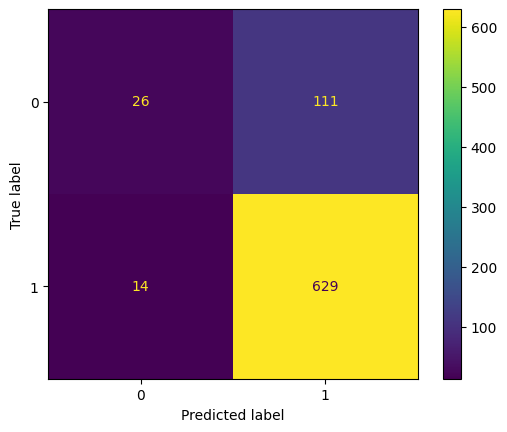

In [61]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test,np.argmax(y_pred.predictions, axis=1)))
disp.plot()
plt.show()

## Utilizando un modelo en español

En este caso, estaré utilizando el modelo [BETO](https://huggingface.co/dccuchile/bert-base-spanish-wwm-cased)

In [42]:
from transformers import BertForSequenceClassification, BertTokenizer
# create the tokenizer and the model

tokenizer = BertTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-cased", do_lower_case=False)
model = BertForSequenceClassification.from_pretrained("dccuchile/bert-base-spanish-wwm-cased", num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [43]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_val_dataset = val_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set the format to PyTorch tensors
tokenized_train_dataset.set_format("torch")
tokenized_val_dataset.set_format("torch")
tokenized_test_dataset.set_format("torch")

Map:   0%|          | 0/3312 [00:00<?, ? examples/s]

Map:   0%|          | 0/1105 [00:00<?, ? examples/s]

Map:   0%|          | 0/780 [00:00<?, ? examples/s]

In [50]:
print(X_train_tokenized[0])
for idx in tokenized_train_dataset['input_ids'][0]:
    print(f"{idx}: {tokenizer.decode(idx)}")

recomendarse famosas momias guanajuato museo horrible exhiben sino exhiben abuelo contó hace años visitar momias entrar panteón pasear tumbas darle propina sepulturero levantaba pesada aldaba después bajar escalera caracol lúgubre cripta ahí cuerpos alineados tras ambos lados estrecho pasillo pasar cristales medio suena escalofriante auténtico ... debieron haber dejado así limitar número personas pudieran visitar diariamente quizás unas haber cobrado bueno ve museo buena fuente ingresos erario bella ciudad recomiendo visitarlo sólo si visitaron todas demás atracciones bellezas ofrece guanajuato si queda tiempo pues bien
4: [CLS]
8110: té
11944: ##trico
6540: divertido
2461: quién
5716: ocurre
1409: hacer
10204: museo
7873: lleno
16422: cadáveres
1901: mom
10396: ##ifica
1192: ##dos
1675: lugar
4758: diferente
3882: pesar
1200: ser
1675: lugar
1231: ten
3953: ##eb
11900: ##roso
2189: pasa
1594: buen
7943: rato
7580: viendo
1953: todas
1901: mom
2924: ##ias
1901: mom
2924: ##ias
26537: c

In [51]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # or "0,1" for multiple GPUs

batch_size = 8
num_epocas = 3

args = TrainingArguments(
    f"bert-finetuning",
    eval_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epocas,
    weight_decay=0.01,
    load_best_model_at_end=True,
    report_to="none"
)

In [52]:
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    tokenizer=tokenizer,
)

/tmp/ipykernel_2563/1101588060.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [53]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,0.321578
2,0.381700,0.355798
3,0.267700,0.480429


TrainOutput(global_step=1242, training_loss=0.29889248649855166, metrics={'train_runtime': 244.2569, 'train_samples_per_second': 40.678, 'train_steps_per_second': 5.085, 'total_flos': 653567861514240.0, 'train_loss': 0.29889248649855166, 'epoch': 3.0})

In [31]:
eval_results = trainer.evaluate(eval_dataset=tokenized_test_dataset)
print(f"Test Evaluation Results: {eval_results}")

Test Evaluation Results: {'eval_loss': 0.296175092458725, 'eval_runtime': 2.8445, 'eval_samples_per_second': 274.213, 'eval_steps_per_second': 34.452, 'epoch': 1.0}


In [56]:
predictions = trainer.predict(tokenized_test_dataset)

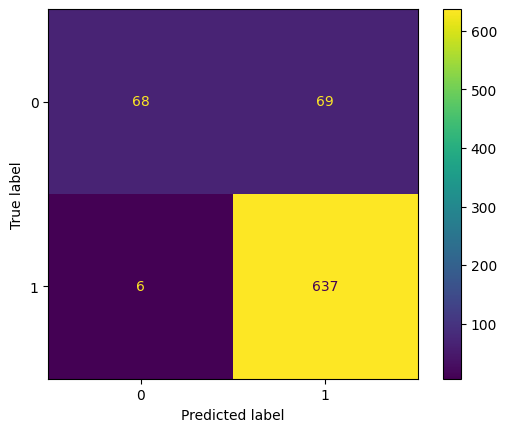

In [60]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, np.argmax(predictions.predictions, axis=1)))
disp.plot()
plt.show()

In [59]:
np.argmax(predictions.predictions, axis=1)

array([0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,